In [1]:
import os
import sys
import torch
import subprocess
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
    version_str="".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".",""),
        f"_pyt{pyt_version_str}"
    ])
    !pip install iopath
    if sys.platform.startswith("linux"):
        print("Trying to install wheel for PyTorch3D")
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
        pip_list = !pip freeze
        need_pytorch3d = not any(i.startswith("pytorch3d==") for  i in pip_list)
    if need_pytorch3d:
        print(f"failed to find/install wheel for {version_str}")
if need_pytorch3d:
    print("Installing PyTorch3D from source")
    !pip install ninja
    !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [2]:
# Import necessary libraries
import numpy as np
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
from IPython.display import clear_output

# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)

In [3]:
# Set the cuda device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [4]:
# Load the mesh (clipMesh.obj)
verts, faces_idx, _ = load_obj("/home/exouser/pose_estim/clipestimator/data/mesh/clipMesh.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object for the clipMesh.
clip_mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures
)

/home/exouser/anaconda3/envs/blvenv/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: /home/exouser/pose_estim/clipestimator/data/mesh/Item.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [5]:
# Initialize a perspective camera.
cameras = FoVPerspectiveCameras(device=device)

# Set blend parameters for silhouette rendering
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Rasterization settings for silhouette rendering
raster_settings_silhouette = RasterizationSettings(
    image_size=256,  # Match the reference image size
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma,
    faces_per_pixel=50,
    bin_size=0,
)

# Silhouette renderer
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)

# Rasterization settings for Phong rendering (for visualization)
raster_settings_phong = RasterizationSettings(
    image_size=256,  # Match the reference image size
    blur_radius=0.0,
    faces_per_pixel=1,
    bin_size=0,
)

# Lighting settings for Phong rendering
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))

# Phong renderer
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings_phong
    ),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)


In [43]:
# Select the viewpoint using spherical angles
distance = 30   # distance from camera to the object
elevation = -15.0   # angle of elevation in degrees
azimuth = 40.0  # No rotation so the camera is positioned on the +Z axis.

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)
print(R, T)

tensor([[[-0.7660,  0.1664, -0.6209],
         [ 0.0000,  0.9659,  0.2588],
         [ 0.6428,  0.1983, -0.7399]]], device='cuda:0') tensor([[ 1.9073e-06, -4.7684e-07,  3.0000e+01]], device='cuda:0')


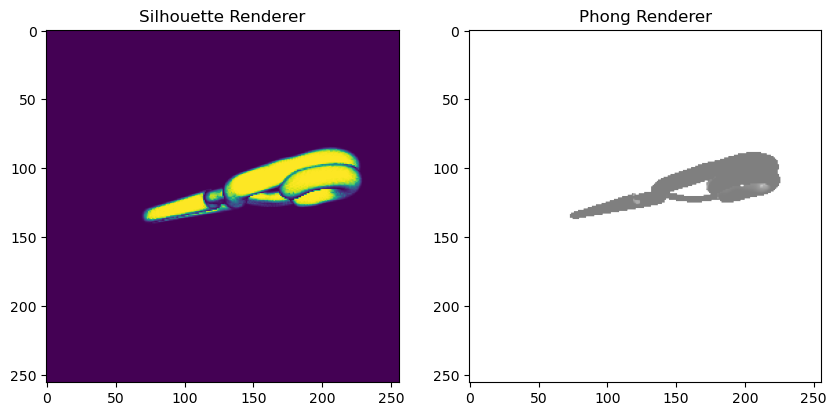

In [44]:
# Render the mesh providing the values of R and T.
silhouette = silhouette_renderer(meshes_world=clip_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=clip_mesh, R=R, T=T)

silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouette.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.title("Silhouette Renderer")
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.title("Phong Renderer")
plt.grid(False)

In [45]:
class Model(nn.Module):
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer
        
        # Get the silhouette of the reference RGB image by finding all non-white pixel values. 
        image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(np.float32))
        self.register_buffer('image_ref', image_ref)
        
        # Create an optimizable parameter for the x, y, z position of the camera. 
        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array([20.0,  20.0, +20.0], dtype=np.float32)).to(meshes.device))

    def forward(self):
        
        # Render the image using the updated camera position. Based on the new position of the 
        # camera we calculate the rotation and translation matrices
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        
        image = self.renderer(meshes_world=self.meshes.clone(), R=R, T=T)
        
        # Calculate the silhouette loss
        loss = torch.mean((image[..., 3] - self.image_ref) ** 2)
        return loss, image

In [46]:
# We will save images periodically and compose them into a GIF.
#filename_output = "./teapot_optimization_demo.gif"
#writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

# Initialize a model using the renderer, mesh and reference image
model = Model(meshes=clip_mesh, renderer=silhouette_renderer, image_ref=image_ref).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

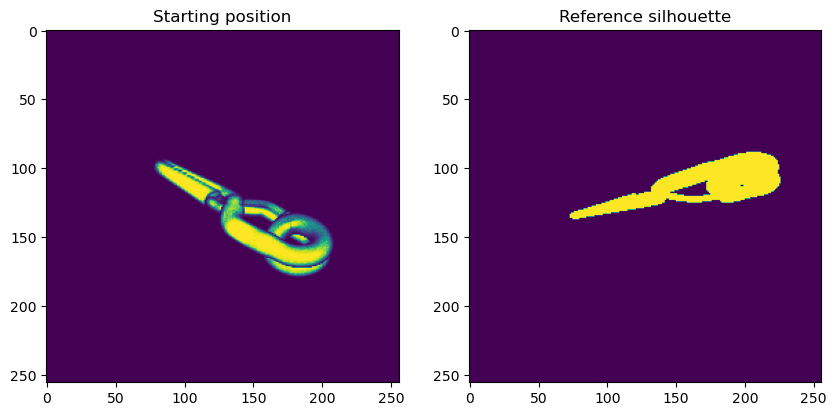

In [47]:
plt.figure(figsize=(10, 10))

_, image_init = model()
plt.subplot(1, 2, 1)
plt.imshow(image_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid(False)
plt.title("Starting position")

plt.subplot(1, 2, 2)
plt.imshow(model.image_ref.cpu().numpy().squeeze())
plt.grid(False)
plt.title("Reference silhouette");

plt.show()

Restart 1/10
Restart 1, Iteration 0, Loss: 0.035204656422138214
Restart 1, Iteration 50, Loss: 0.02719712443649769
Restart 1, Iteration 100, Loss: 0.018440555781126022
Restart 1, Iteration 150, Loss: 0.010117234662175179
Restart 1, Iteration 199, Loss: 0.009729675948619843


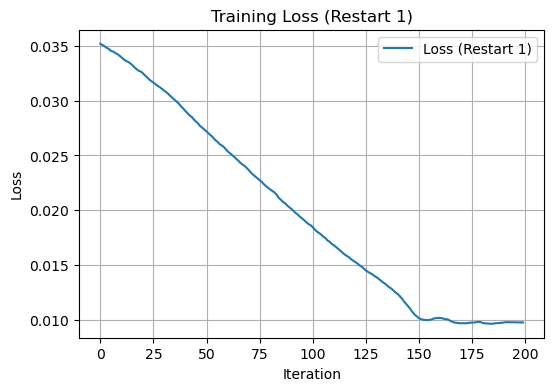

Restart 2/10
Restart 2, Iteration 0, Loss: 0.03631865233182907
Restart 2, Iteration 50, Loss: 0.034707702696323395
Restart 2, Iteration 100, Loss: 0.035877469927072525
Restart 2, Iteration 150, Loss: 0.036502476781606674
Restart 2, Iteration 199, Loss: 0.036885254085063934


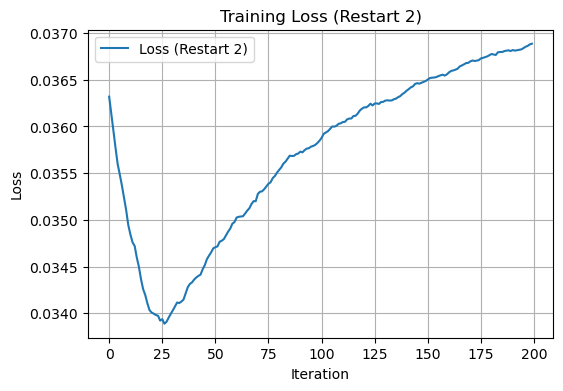

Restart 3/10
Restart 3, Iteration 0, Loss: 0.036065563559532166
Restart 3, Iteration 50, Loss: 0.0309440977871418
Restart 3, Iteration 100, Loss: 0.029018176719546318
Restart 3, Iteration 150, Loss: 0.02668769285082817
Restart 3, Iteration 199, Loss: 0.02335965260863304


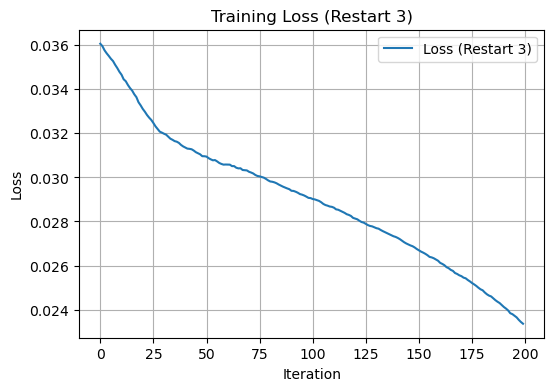

Restart 4/10
Restart 4, Iteration 0, Loss: 0.04129762575030327
Restart 4, Iteration 50, Loss: 0.03628600016236305
Restart 4, Iteration 100, Loss: 0.03617866709828377
Restart 4, Iteration 150, Loss: 0.036370400339365005
Restart 4, Iteration 199, Loss: 0.03663533180952072


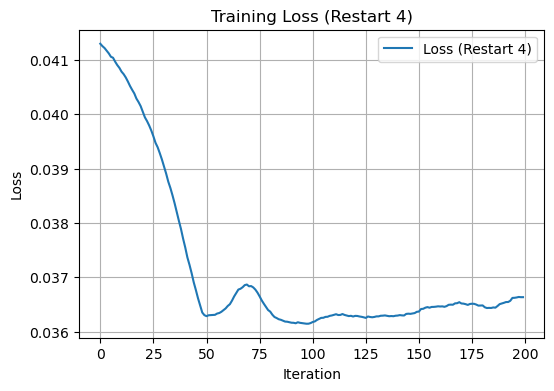

Restart 5/10
Restart 5, Iteration 0, Loss: 0.04936797916889191
Restart 5, Iteration 50, Loss: 0.05106749013066292
Restart 5, Iteration 100, Loss: 0.051586516201496124
Restart 5, Iteration 150, Loss: 0.05175166204571724
Restart 5, Iteration 199, Loss: 0.05194209888577461


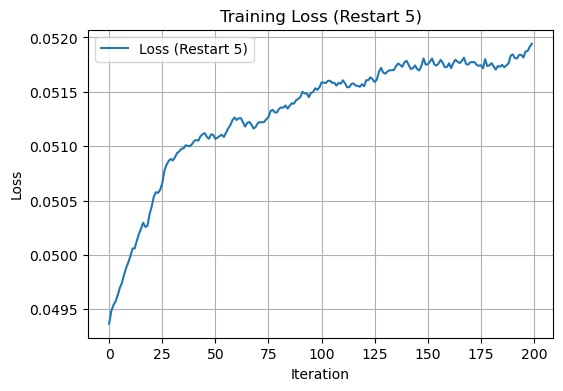

Restart 6/10
Restart 6, Iteration 0, Loss: 0.0557856410741806
Restart 6, Iteration 50, Loss: 0.05070319399237633
Restart 6, Iteration 100, Loss: 0.040461037307977676
Restart 6, Iteration 150, Loss: 0.039664361625909805
Restart 6, Iteration 199, Loss: 0.04682215675711632


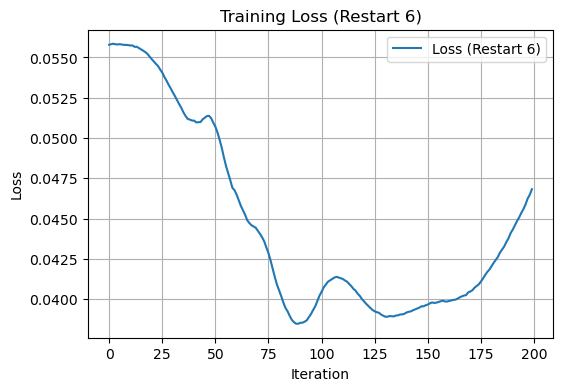

Restart 7/10
Restart 7, Iteration 0, Loss: 0.03453582525253296
Restart 7, Iteration 50, Loss: 0.03182918205857277
Restart 7, Iteration 100, Loss: 0.025299537926912308
Restart 7, Iteration 150, Loss: 0.023629378527402878
Restart 7, Iteration 199, Loss: 0.023535186424851418


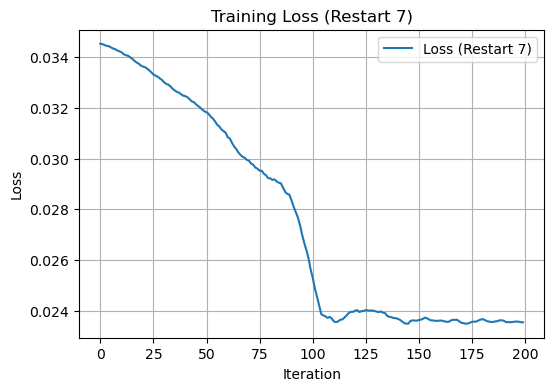

Restart 8/10
Restart 8, Iteration 0, Loss: 0.040863633155822754
Restart 8, Iteration 50, Loss: 0.038937173783779144
Restart 8, Iteration 100, Loss: 0.03794676065444946
Restart 8, Iteration 150, Loss: 0.03762953728437424
Restart 8, Iteration 199, Loss: 0.03755474090576172


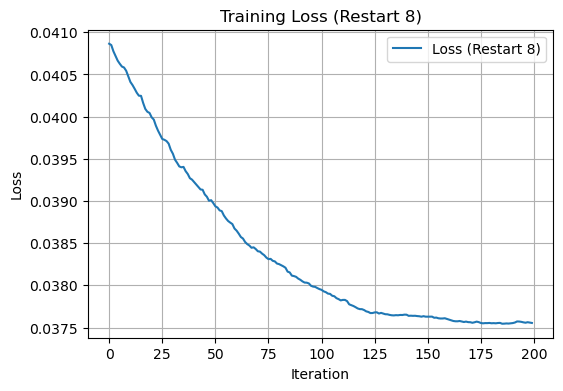

Restart 9/10
Restart 9, Iteration 0, Loss: 0.04063478857278824
Restart 9, Iteration 50, Loss: 0.038185399025678635
Restart 9, Iteration 100, Loss: 0.036442242562770844
Restart 9, Iteration 150, Loss: 0.0299997441470623
Restart 9, Iteration 199, Loss: 0.024556558579206467


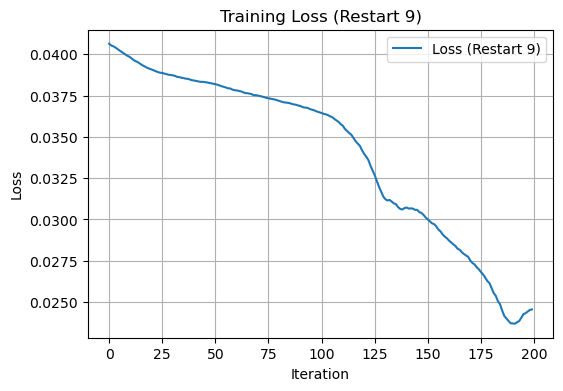

Restart 10/10
Restart 10, Iteration 0, Loss: 0.05220551788806915
Restart 10, Iteration 50, Loss: 0.044833384454250336
Restart 10, Iteration 100, Loss: 0.03978787362575531
Restart 10, Iteration 150, Loss: 0.03248785436153412
Restart 10, Iteration 199, Loss: 0.02935856580734253


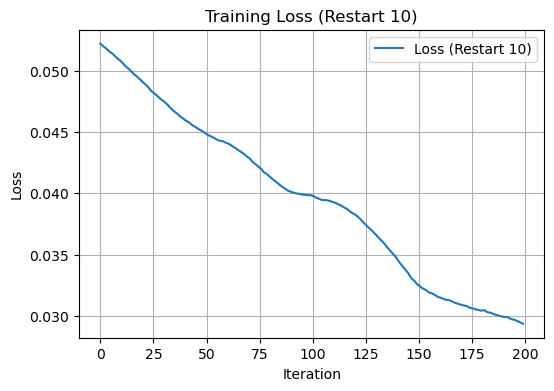

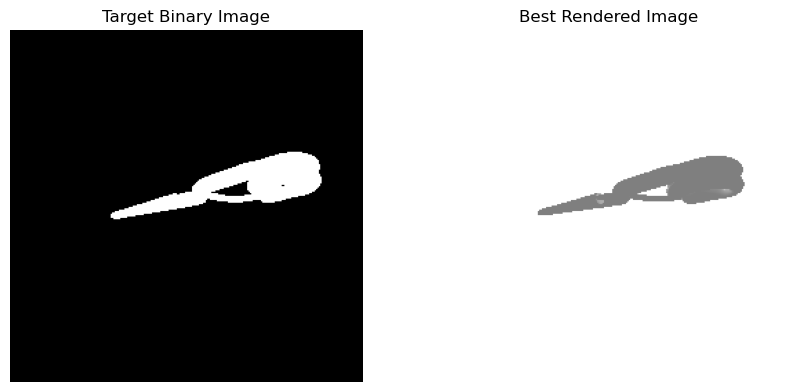

Best Training Results:
Lowest Loss: 0.009729675948619843
Best Camera Position: [20.14827   -5.7280293 21.022453 ]


In [48]:
# RANDOM RESTART WITH DISTANCE CONTROL
# 
# 
# Function to generate a random camera position within a safe distance
def random_camera_position(min_distance, max_distance, device):
    # Generate a random distance within the specified range
    distance = np.random.uniform(min_distance, max_distance)
    
    # Generate random azimuth and elevation angles
    azimuth = np.random.uniform(0, 360)  # Degrees
    elevation = np.random.uniform(-90, 90)  # Degrees
    
    # Convert spherical coordinates to Cartesian coordinates
    x = distance * np.cos(np.radians(elevation)) * np.cos(np.radians(azimuth))
    y = distance * np.cos(np.radians(elevation)) * np.sin(np.radians(azimuth))
    z = distance * np.sin(np.radians(elevation))
    
    # Return the camera position as a torch tensor
    return torch.tensor([x, y, z], device=device, dtype=torch.float32)

# Safe camera position range
min_distance = 40.0  # Closest the camera can be
max_distance = 50.0  # Farthest the camera can be

# Perform multiple random restarts
num_restarts = 10
num_iterations = 200
best_loss = float('inf')
best_camera_position = None
best_rendered_image = None

for restart in range(num_restarts):
    print(f"Restart {restart + 1}/{num_restarts}")
    
    # Randomize the initial camera position
    model.camera_position.data = random_camera_position(min_distance, max_distance, device)

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    loss_values = []

    # Training loop
    for i in range(num_iterations):
        optimizer.zero_grad()
        loss, rendered_image = model()  # Forward pass

        # Backward pass
        loss.backward()

        # Gradient clipping (optional)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Store loss for plotting
        loss_values.append(loss.item())

        # Print progress every 50 iterations
        if i % 50 == 0 or i == num_iterations - 1:
            print(f"Restart {restart + 1}, Iteration {i}, Loss: {loss.item()}")

    # Save the best result
    if loss_values[-1] < best_loss:
        best_loss = loss_values[-1]
        best_camera_position = model.camera_position.data.clone()
        best_rendered_image = rendered_image.clone()

    # Plot the loss curve for this restart
    plt.figure(figsize=(6, 4))
    plt.plot(loss_values, label=f"Loss (Restart {restart + 1})")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(f"Training Loss (Restart {restart + 1})")
    plt.legend()
    plt.grid(True)
    plt.show()

# Use the best camera position for final visualization
model.camera_position.data = best_camera_position

# Render the final image with the best camera position
final_rendered_image = phong_renderer(
    meshes_world=model.meshes.clone(),
    R=look_at_rotation(model.camera_position[None, :], device=model.device),
    T=-torch.bmm(
        look_at_rotation(model.camera_position[None, :], device=model.device).transpose(1, 2),
        model.camera_position[None, :, None]
    )[:, :, 0]
)[0, ..., :3].detach().cpu().numpy()

# Display the best result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(model.image_ref.detach().cpu().squeeze(), cmap="gray")
plt.title("Target Binary Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(final_rendered_image)
plt.title("Best Rendered Image")
plt.axis("off")
plt.show()

# Print the best results
print("Best Training Results:")
print(f"Lowest Loss: {best_loss}")
print(f"Best Camera Position: {best_camera_position.cpu().numpy()}")

Iteration 0, Loss: 0.009725658223032951
Iteration 50, Loss: 0.009769798256456852
Iteration 100, Loss: 0.009750990197062492
Iteration 150, Loss: 0.009748058393597603
Iteration 199, Loss: 0.009747304022312164


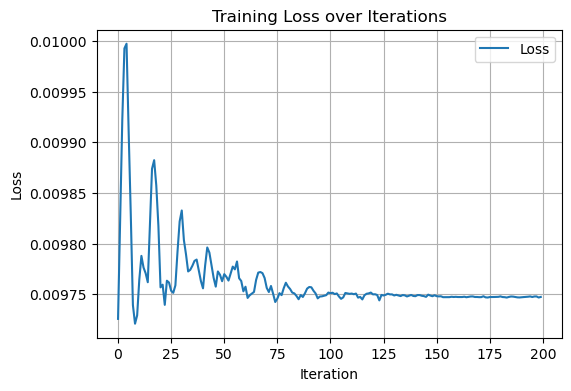

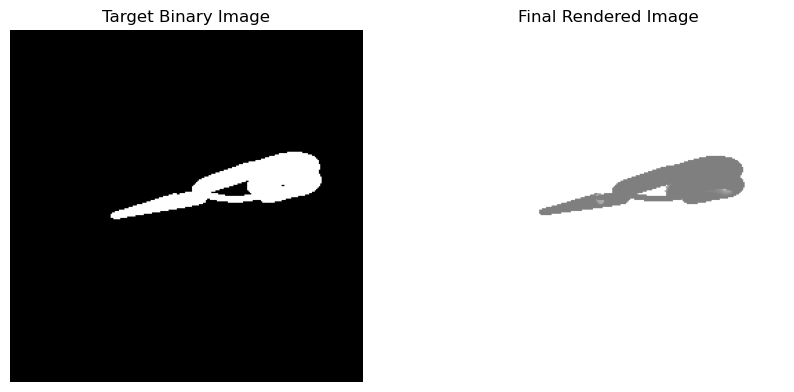

In [49]:
# BASIC TRAINING
# 
# 
# Training loop
num_iterations = 200
loss_values = []

for i in range(num_iterations):
    optimizer.zero_grad()
    loss, rendered_image = model()  # Forward pass

    # Backward pass
    loss.backward()

    # Gradient clipping (optional but helps stabilize training)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

    # Store loss for plotting
    loss_values.append(loss.item())

    # Print progress every 50 iterations or at the last iteration
    if i % 50 == 0 or i == num_iterations - 1:
        print(f"Iteration {i}, Loss: {loss.item()}")

# Plot the loss curve
plt.figure(figsize=(6, 4))
plt.plot(loss_values, label="Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss over Iterations")
plt.legend()
plt.grid(True)
plt.show()

# Display final comparison of target and rendered images
final_rendered_image = phong_renderer(
    meshes_world=model.meshes.clone(),
    R=look_at_rotation(model.camera_position[None, :], device=model.device),
    T=-torch.bmm(
        look_at_rotation(model.camera_position[None, :], device=model.device).transpose(1, 2),
        model.camera_position[None, :, None]
    )[:, :, 0]
)[0, ..., :3].detach().cpu().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(model.image_ref.detach().cpu().squeeze(), cmap="gray")
plt.title("Target Binary Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(final_rendered_image)
plt.title("Final Rendered Image")
plt.axis("off")
plt.show()


In [ ]:
# HARD-CODED 8-QUADRANT STARTS
#
#
# Define 8 hard-coded starting positions in each 3D quadrant
starting_positions = [
    [20.0,  20.0,  20.0],   # Quadrant 1 (+, +, +)
    [-20.0, 20.0,  20.0],   # Quadrant 2 (-, +, +)
    [20.0, -20.0,  20.0],   # Quadrant 3 (+, -, +)
    [-20.0, -20.0, 20.0],   # Quadrant 4 (-, -, +)
    [20.0,  20.0, -20.0],   # Quadrant 5 (+, +, -)
    [-20.0, 20.0, -20.0],   # Quadrant 6 (-, +, -)
    [20.0, -20.0, -20.0],   # Quadrant 7 (+, -, -)
    [-20.0, -20.0, -20.0],  # Quadrant 8 (-, -, -)
]

num_iterations = 300
all_losses = []
best_loss = float('inf')
best_R, best_T = None, None

# Perform training for each starting position
for idx, position in enumerate(starting_positions):
    print(f"Starting training {idx + 1}/8 with initial position: {position}")

    # Reset model with the current starting position
    model.camera_position.data = torch.from_numpy(
        np.array(position, dtype=np.float32)
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    loss_values = []

    # Training loop
    for i in range(num_iterations):
        optimizer.zero_grad()
        loss, _ = model()  # Forward pass

        # Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Store loss for plotting
        loss_values.append(loss.item())

        # Print progress every 50 iterations or at the last iteration
        if i % 50 == 0 or i == num_iterations - 1:
            print(f"Training {idx + 1}, Iteration {i}, Loss: {loss.item()}")

    # Store losses for all trainings
    all_losses.append(loss_values)

    # Get the final R and T for this training
    R = look_at_rotation(model.camera_position[None, :], device=model.device)
    T = -torch.bmm(
        R.transpose(1, 2),
        model.camera_position[None, :, None]
    )[:, :, 0]

    # Keep track of the best (lowest loss) training
    if loss_values[-1] < best_loss:
        best_loss = loss_values[-1]
        best_R, best_T = R.detach().cpu().numpy(), T.detach().cpu().numpy()

    # Generate the final rendered image for this training
    final_rendered_image = phong_renderer(
        meshes_world=model.meshes.clone(), R=R, T=T
    )[0, ..., :3].detach().cpu().numpy()

    # Plot the results for this training
    plt.figure(figsize=(15, 5))

    # Plot the target image
    plt.subplot(1, 3, 1)
    plt.imshow(model.image_ref.detach().cpu().squeeze(), cmap="gray")
    plt.title("Target Binary Image")
    plt.axis("off")

    # Plot the final rendered image
    plt.subplot(1, 3, 2)
    plt.imshow(final_rendered_image)
    plt.title(f"Final Rendered Image (Training {idx + 1})")
    plt.axis("off")

    # Plot the loss curve
    plt.subplot(1, 3, 3)
    plt.plot(loss_values, label="Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve (Training {idx + 1})")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Print the best R and T values
print("Best Training Results:")
print(f"Lowest Loss: {best_loss}")
print(f"Best R (Rotation Matrix):\n{best_R}")
print(f"Best T (Translation Vector):\n{best_T}")